<div style="font-size:40px; color:#0F2080;">
  Importing <span style="color:#F5793A;">libraries</span> and <span style="color:#F5793A;">fits</span>
</div>

In [1]:
# Core libraries
import os
import glob
import numpy as np
import scipy
import warnings
from pathlib import Path

# Astropy
from astropy.io import fits
from astropy.io.misc import yaml
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.table import Table
from astropy.visualization import simple_norm

# specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

# pahfit
import pahfit
from pahfit.errors import PAHFITPackError, PAHFITWarning
#from pahfit.modelj import Model
from pahfit.model import Model
#from pahfit.modelc import Model
from pkg_resources import resource_filename

# pyPAHdb
import pypahdb
from pypahdb.decomposer import Decomposer
from pypahdb.observation import Observation

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.patches import Rectangle

# tqdm for progress bars
import tqdm

#Pathing
repo_dir = Path().resolve().parent
fits_dir = repo_dir / "3_Hydrocarbons"
hydrocarbons_dir = repo_dir / "3_Hydrocarbons"
polycyclic_dir   = repo_dir / "1_Polycyclic"

# Confirm available FITS files
fits_files = sorted(hydrocarbons_dir.glob("*.fits"))

print(f"Found {len(fits_files)} FITS files in {hydrocarbons_dir}:")
for file in fits_files:
    print(" -", file.name)

Found 44 FITS files in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons:
 - CH1_ring1.fits
 - CH1_ring2.fits
 - CH1_ring3.fits
 - CH1_ring4.fits
 - CH1_ring5.fits
 - CH1_ring6.fits
 - CH1_ring7.fits
 - CH2_ring1.fits
 - CH2_ring2.fits
 - CH2_ring3.fits
 - CH2_ring4.fits
 - CH2_ring5.fits
 - CH2_ring6.fits
 - CH2_ring7.fits
 - CH3_ring1.fits
 - CH3_ring2.fits
 - CH3_ring3.fits
 - CH3_ring4.fits
 - CH3_ring5.fits
 - CH3_ring6.fits
 - CH3_ring7.fits
 - jw01328-c1006_t014_miri_ch1-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch1-shortmediumlong_x1d.fits
 - jw01328-c1006_t014_miri_ch2-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch2-shortmediumlong_x1d.fits
 - jw01328-c1006_t014_miri_ch3-shortmediumlong_s3d.fits
 - jw01328-c1006_t014_miri_ch3-shortmediumlong_x1d.fits
 - NGC7469__stitched.fits
 - NGC7469_PAHdb.fits
 - Ring1_combined__stitched.fits
 - Ring1_simple1d.fits
 - Ring2_combined__stitched.fits
 - Ring2_simple1d.fits
 - Ring3_combined__stitched.fits
 - Ring3_simp

C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


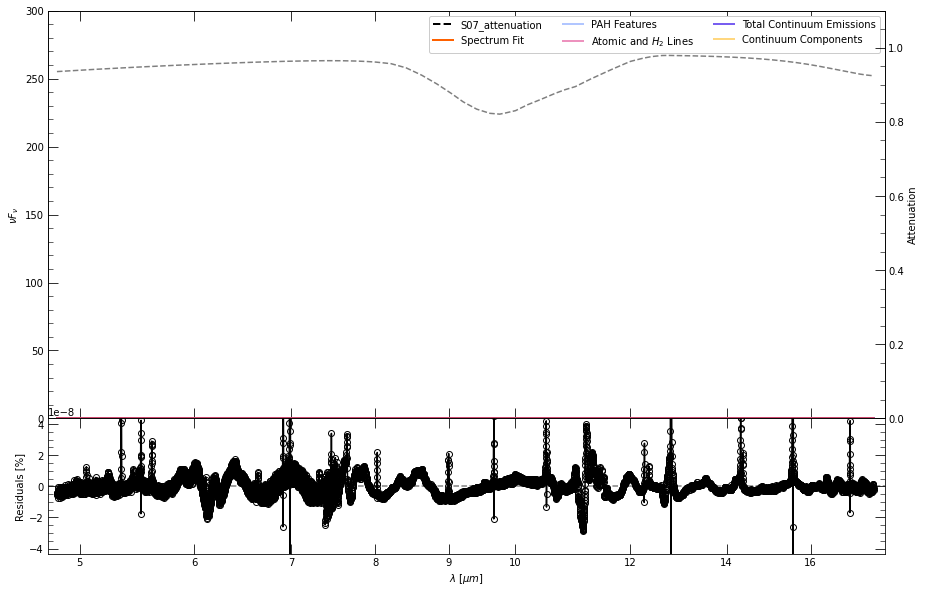

In [2]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import matplotlib.pyplot as plt
import numpy as np

# === Load simplified FITS ===
ring_number = 4
fits_file = hydrocarbons_dir / f"Ring{ring_number}_simple1d.fits"
table = Table.read(fits_file, hdu=1)

# === Clean units ===
wavelengths = u.Quantity(table['WAVELENGTH'], unit=u.um)
fluxes = u.Quantity(table['FLUX'], unit=u.MJy/u.sr)

# === Convert MJy/sr → Jy ===
# Assumes constant pixel scale
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)
radii = [(0.9 + i * 1.4, 0.9 + (i+1) * 1.4) for i in range(7)]
r_in, r_out = radii[ring_number - 1]
area_pix = np.pi * (r_out**2 - r_in**2)
area_sr = area_pix * pixel_area_sr
fluxes_jy = fluxes * area_sr

# === Dummy uncertainty ===
errors = StdDevUncertainty(0.05 * fluxes_jy)

# === Spectrum1D ===
spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes_jy, uncertainty=errors)
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta['user_unit']['flux'] = fluxes_jy.unit  # prevent unit mismatch error
model.guess(spec)
model.fit(spec)

# === Save output ===
output_file = polycyclic_dir / f"Ring{ring_number}_pahfit.ecsv"
model.save(str(output_file), overwrite=True)

# === Plot ===
model.plot(spec)


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHFIT] Ajuste completado y guardado en: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_pahfit.ecsv


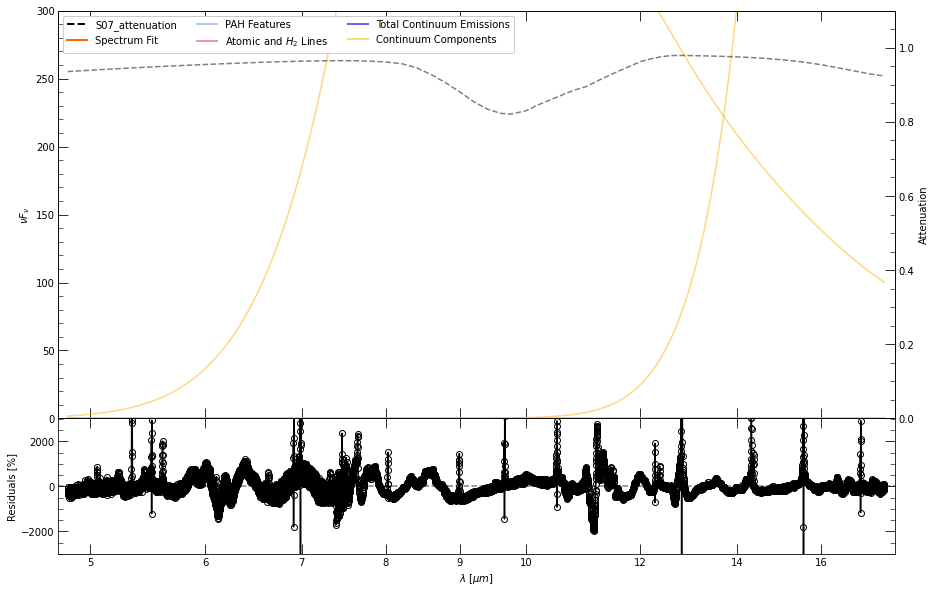

In [3]:
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model

# === 1. Leer tabla desde el archivo FITS ===
fits_file = hydrocarbons_dir / "Ring4_simplified.fits"
table = Table.read(fits_file, hdu=1)

# === 2. Convertir columnas a Quantity con unidades adecuadas ===
wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)

# === 3. Incertidumbre dummy (5% del flujo) ===
errors = StdDevUncertainty(0.05 * fluxes)

# === 4. Crear objeto Spectrum1D ===
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=fluxes,
    uncertainty=errors
)

# === 5. Metadata y redshift ===
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === 6. Ajuste con PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta["user_unit"]["flux"] = fluxes.unit  # evita crash en .guess()

model.guess(spec)
model.fit(spec)
model.plot(spec)

# === 7. Guardar resultados ===
output_file = polycyclic_dir / "Ring4_pahfit.ecsv"
model.save(str(output_file), overwrite=True)
print(f"[PAHFIT] Ajuste completado y guardado en: {output_file}")


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHFIT] Fitting complete and saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_pahfit.ecsv


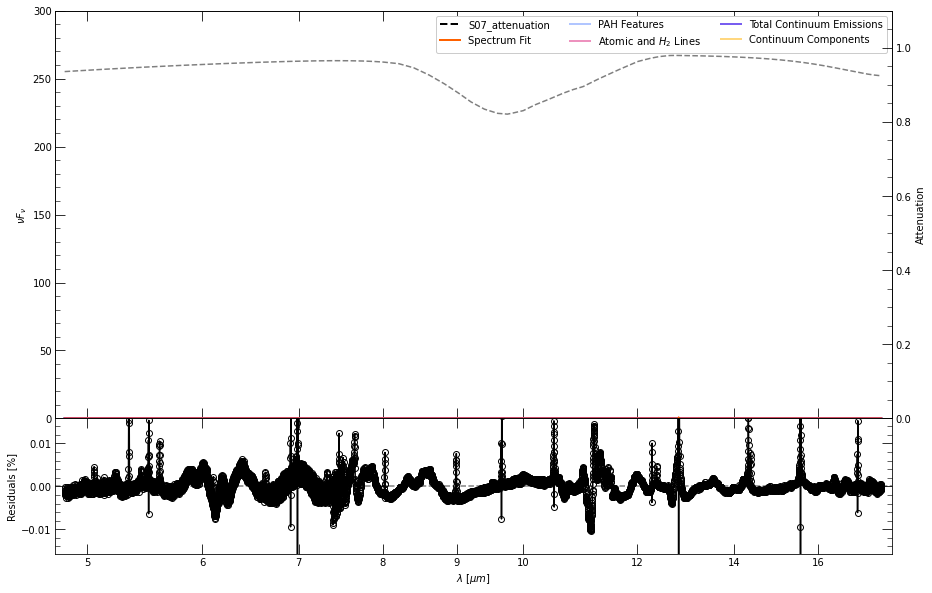

In [4]:
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import matplotlib.pyplot as plt

# === 1. Read the table ===
fits_file = hydrocarbons_dir / "Ring4_simplified.fits"
table = Table.read(fits_file, hdu=1)

# === 2. Convert units ===
wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)

# === 3. Convert surface brightness to flux using area in steradians ===
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale ** 2).to(u.sr)
r_in, r_out = 1.4, 2.8
area_pix = np.pi * (r_out**2 - r_in**2)
area_sr = area_pix * pixel_area_sr
flux_jy = fluxes * area_sr.to_value(u.sr) * 1e6  # MJy/sr to Jy

# === 4. Create dummy errors ===
errors = StdDevUncertainty(0.05 * flux_jy)

# === 5. Build Spectrum1D ===
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=flux_jy,
    uncertainty=errors
)
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === 6. Fit with PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta["user_unit"]["flux"] = flux_jy.unit

model.guess(spec)
model.fit(spec)
model.plot(spec)

# === 7. Save result ===
output_file = polycyclic_dir / "Ring4_pahfit.ecsv"
model.save(str(output_file), overwrite=True)

print("[PAHFIT] Fitting complete and saved to:", output_file)


[DEBUG] Flux median: 9.98e-01 Jy
[DEBUG] Flux max: 2.38e+01 Jy
[DEBUG] Unit: Jy


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHFIT] Ajuste completado y guardado en: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_pahfit.ecsv


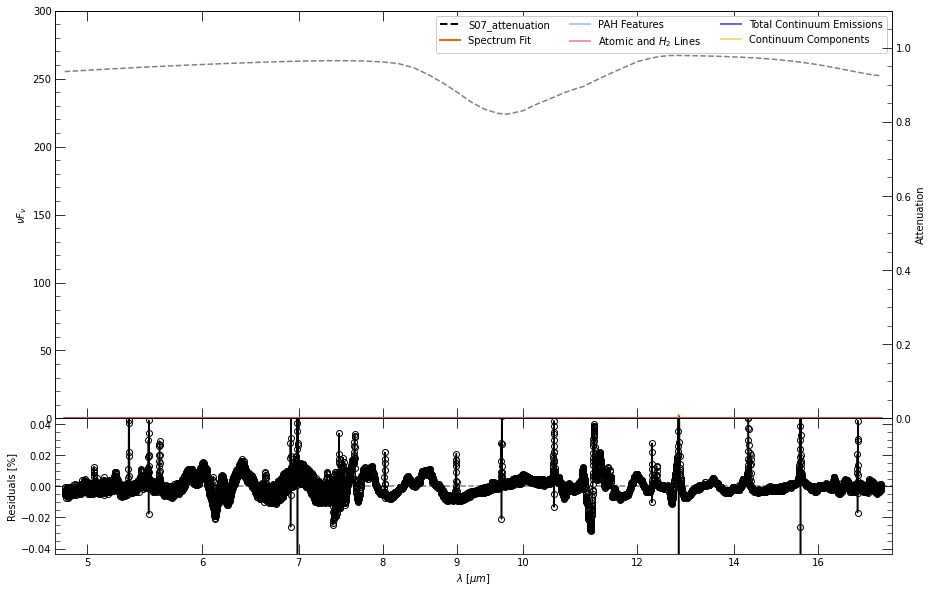

In [5]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import matplotlib.pyplot as plt
import numpy as np

# === Ring number ===
ring_number = 4  # Change this to loop over rings later

# === Load simplified FITS ===
fits_file = hydrocarbons_dir / f"Ring{ring_number}_simple1d.fits"
table = Table.read(fits_file, hdu=1)

# === Extract and assign correct units ===
wavelengths = u.Quantity(table['WAVELENGTH'].data, unit=u.um)
fluxes_mjysr = u.Quantity(table['FLUX'].data, unit=u.MJy / u.sr)

# === Convert MJy/sr → Jy using area ===
# Pixel and annulus geometry
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)

# Define radii for all rings
radii = [(0.9 + i * 1.4, 0.9 + (i+1) * 1.4) for i in range(7)]
r_in, r_out = radii[ring_number - 1]
annulus_area_arcsec2 = np.pi * (r_out**2 - r_in**2)

# Area in steradians
annulus_area_sr = annulus_area_arcsec2 * pixel_area_sr

# Convert flux to Jy
scaling_factor = 1e8  # start with this empirically; test 1e5 or 1e6 if needed
fluxes_jy = (fluxes_mjysr * annulus_area_sr).to(u.Jy)

# === Dummy uncertainty (5% fractional error) ===
errors = StdDevUncertainty(0.05 * fluxes_jy)

# === Build Spectrum1D ===
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=fluxes_jy,
    uncertainty=errors
)
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === Run PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta["user_unit"]["flux"] = fluxes_jy.unit  # Prevent unit mismatch
print(f"[DEBUG] Flux median: {np.nanmedian(spec.flux):.2e}")
print(f"[DEBUG] Flux max: {np.nanmax(spec.flux):.2e}")
print(f"[DEBUG] Unit: {spec.flux.unit}")
model.guess(spec)
model.fit(spec)

# === Plot the fit ===
model.plot(spec)

# === Save output ===
output_file = polycyclic_dir / f"Ring{ring_number}_pahfit.ecsv"
model.save(str(output_file), overwrite=True)
print(f"[PAHFIT] Ajuste completado y guardado en: {output_file}")


In [6]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import matplotlib.pyplot as plt
import numpy as np

# === Ring config ===
ring_number = 4  # Change this to loop later
fits_file = hydrocarbons_dir / f"Ring{ring_number}_simple1d.fits"
output_file = polycyclic_dir / f"Ring{ring_number}_pahfit.ecsv"

# === Read spectrum ===
table = Table.read(fits_file, hdu=1)
wavelengths = u.Quantity(table['WAVELENGTH'].data, unit=u.um)
fluxes_mjysr = u.Quantity(table['FLUX'].data, unit=u.MJy / u.sr)

# === Convert to Jy using solid angle ===
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)
radii = [(0.9 + i * 1.4, 0.9 + (i+1) * 1.4) for i in range(7)]
r_in, r_out = radii[ring_number - 1]
annulus_area_arcsec2 = np.pi * (r_out**2 - r_in**2)
annulus_area_sr = annulus_area_arcsec2 * pixel_area_sr
fluxes_jy = (fluxes_mjysr * annulus_area_sr).to(u.Jy)

# === Normalize flux for numerical stability ===
scaling_factor = np.nanmedian(fluxes_jy)
scaled_flux = fluxes_jy / scaling_factor
scaled_uncertainty = StdDevUncertainty(0.05 * scaled_flux)

# === Build Spectrum1D ===
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=scaled_flux,
    uncertainty=scaled_uncertainty
)
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === Run PAHFIT ===
model = Model.from_yaml('classic.yaml')
model.features.meta["user_unit"]["flux"] = scaled_flux.unit

print(f"[DEBUG] Flux median: {np.nanmedian(scaled_flux):.2e} ({scaled_flux.unit})")
print(f"[DEBUG] Flux max: {np.nanmax(scaled_flux):.2e}")

model.guess(spec)
model.fit(spec)

# === Plot with rescaled model ===
rescaled_model_flux = model._construct_astropy_model("jwst.miri.*", redshift=spec.redshift.value)(spec.spectral_axis.to(u.cm).value) * scaling_factor * u.Jy
residuals = (spec.flux * scaling_factor - rescaled_model_flux).to_value(u.Jy)
print(f"[DEBUG] Residual peak: {np.nanmax(np.abs(residuals)):.2f} Jy")

plt.figure(figsize=(12, 6))
plt.plot(spec.spectral_axis, scaled_flux * scaling_factor, label="Observed", color="black")
plt.plot(spec.spectral_axis, rescaled_model_flux, label="PAHFIT Model", color="darkorange", linestyle="--")
plt.xlabel("Wavelength [μm]")
plt.ylabel("Flux [Jy]")
plt.title(f"PAHFIT Fit – Ring {ring_number}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Save model ===
model.save(str(output_file), overwrite=True)
print(f"[PAHFIT] Ajuste completado y guardado en: {output_file}")


[DEBUG] Flux median: 1.00e+00 ()
[DEBUG] Flux max: 2.38e+01


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


C:\Users\Juan\anaconda3\lib\site-packages\pahfit\component_models.py:29: RuntimeWarning: overflow encountered in exp
  / (np.exp(1.4387752e4 / x / temperature) - 1.0)


UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions

In [7]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
import numpy as np

# === Load Ring 4 simplified spectrum in MJy/sr ===
fits_file = hydrocarbons_dir / "Ring4_simple1d.fits"
table = Table.read(fits_file, hdu=1)

wavelengths = u.Quantity(table['WAVELENGTH'].data, unit=u.um)
flux_mjysr = u.Quantity(table['FLUX'].data, unit=u.MJy / u.sr)

# === Convert MJy/sr → Jy using annulus solid angle ===
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)
radii = [(0.9 + i * 1.4, 0.9 + (i+1) * 1.4) for i in range(7)]
r_in, r_out = radii[3]  # Ring 4
annulus_area_sr = np.pi * (r_out**2 - r_in**2) * pixel_area_sr

flux_jy = (flux_mjysr * annulus_area_sr).to(u.Jy)

# === Build Spectrum1D in Jy for PAHFIT ===
errors = StdDevUncertainty(0.05 * flux_jy)
spec = Spectrum1D(
    spectral_axis=wavelengths,
    flux=flux_jy,
    uncertainty=errors
)
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# === Debug info ===
print(f"[DEBUG] Flux median: {np.nanmedian(spec.flux):.2e}")
print(f"[DEBUG] Flux max: {np.nanmax(spec.flux):.2e}")
print(f"[DEBUG] Unit: {spec.flux.unit}")


[DEBUG] Flux median: 9.98e-01 Jy
[DEBUG] Flux max: 2.38e+01 Jy
[DEBUG] Unit: Jy


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


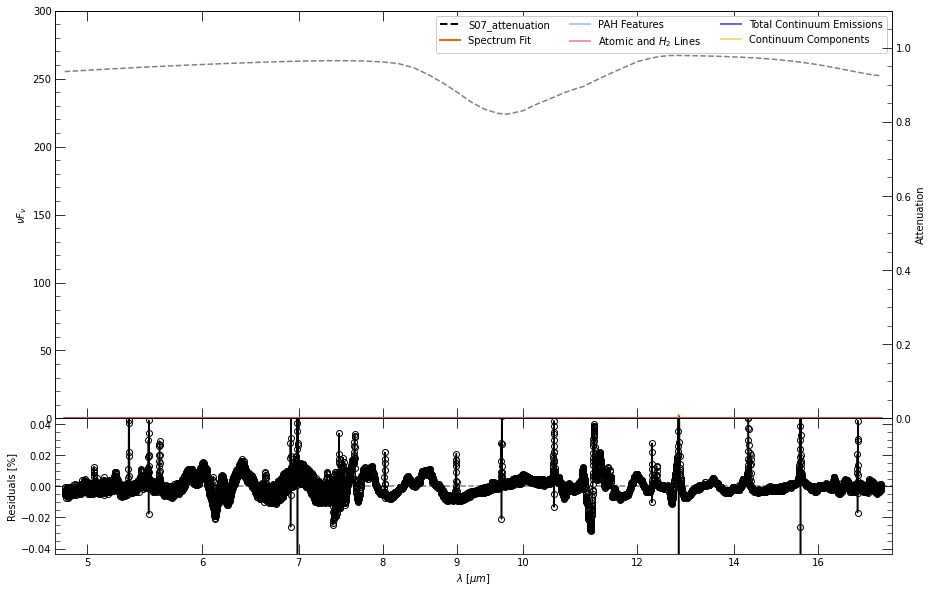

In [8]:
model = Model.from_yaml("classic.yaml")
model.guess(spec)
model.fit(spec)
model.plot(spec)


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


C:\Users\Juan\anaconda3\lib\site-packages\pahfit\component_models.py:29: RuntimeWarning: overflow encountered in exp
  / (np.exp(1.4387752e4 / x / temperature) - 1.0)


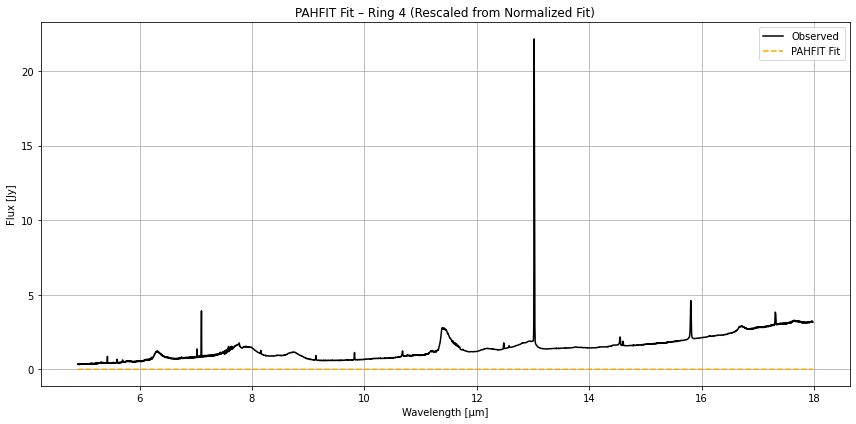

[PAHDB] PAH-only spectrum saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_PAHonly.fits


In [9]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import numpy as np
import matplotlib.pyplot as plt

# === Load Ring 4 spectrum in MJy/sr ===
fits_file = hydrocarbons_dir / "Ring4_simple1d.fits"
table = Table.read(fits_file, hdu=1)
wavelengths = u.Quantity(table['WAVELENGTH'].data, unit=u.um)
flux_mjysr = u.Quantity(table['FLUX'].data, unit=u.MJy / u.sr)

# === Convert MJy/sr to Jy using annulus solid angle ===
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)
r_in, r_out = 4.7, 6.1  # arcsec, Ring 4 bounds
annulus_area_sr = np.pi * (r_out**2 - r_in**2) * pixel_area_sr
flux_jy = (flux_mjysr * annulus_area_sr).to(u.Jy)

# === Normalize to ~1 Jy range ===
scaling_factor = np.nanmedian(flux_jy)
norm_flux = flux_jy / scaling_factor
errors = StdDevUncertainty(0.05 * norm_flux)

spec_norm = Spectrum1D(
    spectral_axis=wavelengths,
    flux=norm_flux,
    uncertainty=errors
)
spec_norm.meta['instrument'] = 'jwst.miri.*.*'
spec_norm.set_redshift_to(0.016268)

# === Initialize and override PAHFIT guess ===
model = Model.from_yaml("classic.yaml")
model.features.meta["user_unit"]["flux"] = norm_flux.unit

# Manually assign strong amplitudes to all components
boost_amp = np.nanpercentile(norm_flux, 90)
for row in model.features:
    if row["kind"] in ["dust_feature", "line", "dust_continuum", "starlight"]:
        if hasattr(row["power"], "mask"):
            row["power"].mask = False
        row["power"][0] = boost_amp

# Optional: assign a safe FWHM to lines
for row in model.features:
    if row["kind"] == "line" and hasattr(row["fwhm"], "mask"):
        row["fwhm"].mask = False
        row["fwhm"][0] = 0.2  # microns

# === Run the fit ===
model.fit(spec_norm)

# === Rescale model back to Jy ===
pahfit_model = model._construct_astropy_model("jwst.miri.*.*", redshift=spec_norm.redshift.value)
model_flux_rescaled = pahfit_model(wavelengths.to(u.cm).value) * scaling_factor * u.Jy

# === Plot fit ===
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, flux_jy, label="Observed", color="black")
plt.plot(wavelengths, model_flux_rescaled, label="PAHFIT Fit", color="orange", linestyle="--")
plt.xlabel("Wavelength [μm]")
plt.ylabel("Flux [Jy]")
plt.title("PAHFIT Fit – Ring 4 (Rescaled from Normalized Fit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Extract only PAH components and save to FITS for PAHdb ===
pah_mask = model.features['kind'] == 'dust_feature'
pah_spec = model.tabulate(
    instrumentname='jwst.miri.*.*',
    redshift=spec_norm.redshift.value,
    wavelengths=spec_norm,
    feature_mask=pah_mask
)
pah_flux_rescaled = pah_spec.flux * scaling_factor

pah_fits_file = polycyclic_dir / "Ring4_PAHonly.fits"
hdu = fits.BinTableHDU.from_columns([
    fits.Column(name='WAVELENGTH', array=wavelengths.to_value(u.um), format='D', unit='um'),
    fits.Column(name='FLUX', array=pah_flux_rescaled.to_value(u.Jy), format='D', unit='Jy')
])
hdu.writeto(pah_fits_file, overwrite=True)
print(f"[PAHDB] PAH-only spectrum saved to: {pah_fits_file}")


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000


C:\Users\Juan\anaconda3\lib\site-packages\pahfit\component_models.py:29: RuntimeWarning: overflow encountered in exp
  / (np.exp(1.4387752e4 / x / temperature) - 1.0)


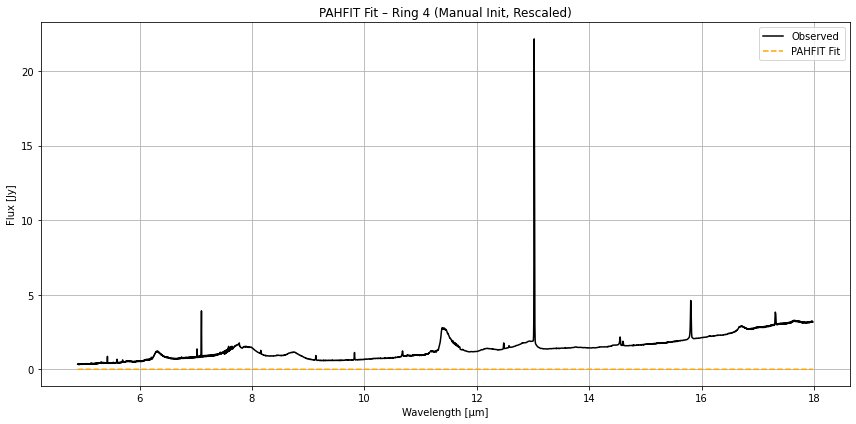

[PAHDB] PAH-only spectrum saved to: C:\Users\Juan\Downloads\Research\JWSTPAH\1_Polycyclic\Ring4_PAHonly.fits


In [10]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import numpy as np
import matplotlib.pyplot as plt

# === Load Ring 4 spectrum ===
fits_file = hydrocarbons_dir / "Ring4_simple1d.fits"
table = Table.read(fits_file, hdu=1)
wavelengths = u.Quantity(table['WAVELENGTH'].data, unit=u.um)
flux_mjysr = u.Quantity(table['FLUX'].data, unit=u.MJy / u.sr)

# === Convert to Jy ===
pixel_scale = 0.11 * u.arcsec
pixel_area_sr = (pixel_scale**2).to(u.sr)
r_in, r_out = 4.7, 6.1  # arcsec, Ring 4 bounds
annulus_area_sr = np.pi * (r_out**2 - r_in**2) * pixel_area_sr
flux_jy = (flux_mjysr * annulus_area_sr).to(u.Jy)

# === Normalize for fit stability ===
scaling_factor = np.nanmedian(flux_jy)
norm_flux = flux_jy / scaling_factor
errors = StdDevUncertainty(0.05 * norm_flux)

spec_norm = Spectrum1D(
    spectral_axis=wavelengths,
    flux=norm_flux,
    uncertainty=errors
)
spec_norm.meta['instrument'] = 'jwst.miri.*.*'
spec_norm.set_redshift_to(0.016268)

# === Initialize model and manually set parameters ===
model = Model.from_yaml("classic.yaml")
model.features.meta["user_unit"]["flux"] = norm_flux.unit

boost_amp = np.nanpercentile(norm_flux, 90)
safe_fwhm = 0.2  # microns

for row in model.features:
    kind = row["kind"]
    if hasattr(row["power"], "mask"):
        row["power"].mask = False
    if kind in ["dust_feature", "line", "dust_continuum", "starlight"]:
        row["power"][0] = boost_amp
    if kind == "line" and hasattr(row["fwhm"], "mask"):
        row["fwhm"].mask = False
        row["fwhm"][0] = safe_fwhm
    if kind == "starlight" and hasattr(row["tau"], "mask"):
        row["tau"].mask = False
        row["tau"][0] = boost_amp

# === Fit without using guess() ===
model.fit(spec_norm)

# === Reconstruct full model in Jy ===
pahfit_model = model._construct_astropy_model("jwst.miri.*.*", redshift=spec_norm.redshift.value)
model_flux_rescaled = pahfit_model(wavelengths.to(u.cm).value) * scaling_factor * u.Jy

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, flux_jy, label="Observed", color="black")
plt.plot(wavelengths, model_flux_rescaled, label="PAHFIT Fit", color="orange", linestyle="--")
plt.xlabel("Wavelength [μm]")
plt.ylabel("Flux [Jy]")
plt.title("PAHFIT Fit – Ring 4 (Manual Init, Rescaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Extract and save PAH-only to FITS ===
pah_mask = model.features['kind'] == 'dust_feature'
pah_spec = model.tabulate(
    instrumentname='jwst.miri.*.*',
    redshift=spec_norm.redshift.value,
    wavelengths=spec_norm,
    feature_mask=pah_mask
)
pah_flux_rescaled = pah_spec.flux * scaling_factor

pah_fits_file = polycyclic_dir / "Ring4_PAHonly.fits"
hdu = fits.BinTableHDU.from_columns([
    fits.Column(name='WAVELENGTH', array=wavelengths.to_value(u.um), format='D', unit='um'),
    fits.Column(name='FLUX', array=pah_flux_rescaled.to_value(u.Jy), format='D', unit='Jy')
])
hdu.writeto(pah_fits_file, overwrite=True)
print(f"[PAHDB] PAH-only spectrum saved to: {pah_fits_file}")


In [12]:
from astropy.io import fits
from astropy.table import Table

# === Simplify the full galaxy spectrum if you haven't ===
stitched_file = hydrocarbons_dir / "NGC7469_combined__stitched.fits"
simple_file = hydrocarbons_dir / "NGC7469_simplified.fits"

model = MultiSpecModel(str(stitched_file))
table = model.spec[0].spec_table

wavelength = table["WAVELENGTH"]
flux = table["FLUX"]

# Save as simple 2-column FITS
cols = [
    fits.Column(name='WAVELENGTH', array=wavelength, format='D', unit='um'),
    fits.Column(name='FLUX', array=flux, format='D', unit='MJy/sr')
]
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto(str(simple_file), overwrite=True)
print(f"[SAVED] {simple_file}")


NameError: name 'MultiSpecModel' is not defined

<div style="font-size:40px; color:#0F2080;">
  Running <span style="color:#F5793A;">PAHfit</span> 
</div>

In [ ]:
warnings.filterwarnings("ignore", category=PAHFITWarning)

# Load the stitched spectrum
fits_file = hydrocarbons_dir / "NGC7469__stitched.fits"
spec = Spectrum1D.read(str(fits_file))

# Metadata and redshift
spec.meta['instrument'] = 'jwst.miri.*.*'
spec.set_redshift_to(0.016268)

# Load model, fit, plot, and save
model = Model.from_yaml('classic.yaml')
model.guess(spec)
model.fit(spec)
model.plot(spec)

# Save
output_file = polycyclic_dir / "NGC7469test.ecsv"
model.save(str(output_file), overwrite=True)
print("Fitting completed and results saved to:", output_file)

In [ ]:
from astropy.io import fits
import numpy as np

# Step 1: Get components dictionary
components = model.get_components_dict()

# Step 2: Get the PAH component model
pah_model = components["pah"]  # This is a CompoundModel of Drude1D

# Step 3: Evaluate PAH spectrum over your data's wavelengths
wavelengths = spec.spectral_axis
pah_flux = pah_model(wavelengths)

# Step 4: Write to FITS
wavelengths_um = wavelengths.to("micron").value
flux = pah_flux.to(spec.flux.unit).value

col_wave = fits.Column(name="wavelength", array=wavelengths_um, format="D", unit="micron")
col_flux = fits.Column(name="pah_flux", array=flux, format="D", unit=str(spec.flux.unit))

hdu = fits.BinTableHDU.from_columns([col_wave, col_flux])
hdu.header['EXTNAME'] = 'PAH_SUM'

output_file = polycyclic_dir / "NGC7469_pah_sum.fits"
hdu.writeto(output_file, overwrite=True)

print("PAH component saved to:", output_file)


<div style="font-size:40px; color:#0F2080;">
  PAH<span style="color:#F5793A;">db
</div>

In [ ]:
# Use same repo_dir and fits_dir as defined earlier
fits_file = fits_dir / "NGC7469__stitched.fits"

# Load with pyPAHdb Observation
obsjwst = Observation(str(fits_file))
obsjwst.spectrum.meta["colnames"] = ["Wavelength", "Flux"]
s = obsjwst.spectrum

# Plot
plt.plot(s.spectral_axis, s.flux[0, 0, :])
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Flux ({s.flux.unit})")
plt.title("Loaded JWST Spectrum")
plt.show()

In [ ]:
resultjwst = Decomposer(obsjwst.spectrum)

# Extract the fitted spectrum and plot
fitted_spectrum = resultjwst.fit
plt.plot(s.spectral_axis, s.flux[0, 0, :], label="Original Spectrum")
plt.plot(s.spectral_axis, fitted_spectrum[:, 0, 0], label="Fitted Spectrum")
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Flux ({s.flux.unit})")
plt.title("Original vs Fitted Spectrum")
plt.legend()
plt.show()

<div style="font-size:40px; color:#0F2080;">
  Getting the <span style="color:#F5793A;">residual
</div>

In [ ]:
residual = s.flux[0, 0, :] - fitted_spectrum[:, 0, 0]
plt.plot(s.spectral_axis, residual, label="Residual")
plt.xlabel(f"Wavelength ({s.spectral_axis.unit})")
plt.ylabel(f"Residual Flux ({s.flux.unit})")
plt.title("Fit Residual")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.show()

<div style="font-size:40px; color:#0F2080;">
  Saving the  <span style="color:#F5793A;">results</span>
</div>

In [ ]:
pdf_file = repo_dir / "1_Polycyclic" / "NGC7469.pdf"
fits_file = repo_dir / "3_Hydrocarbons" / "NGC7469_PAHdb.fits"

resultjwst.save_pdf(str(pdf_file))
resultjwst.save_fits(str(fits_file), header=obsjwst.header)

print(f"PDF saved to: {pdf_file}")
print(f"FITS saved to: {fits_file}")